In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
from ultralytics import YOLO
import numpy as np
import base64
import io
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<IPython.core.display.Javascript object>


0: 480x640 5 persons, 9 chairs, 2 laptops, 425.4ms
Speed: 1.8ms preprocess, 425.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


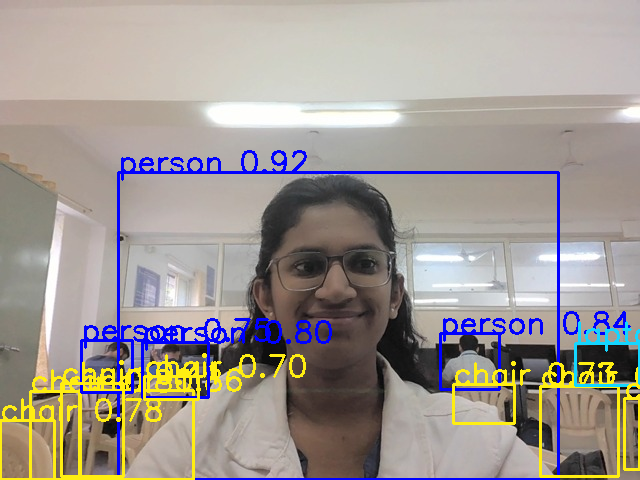


0: 480x640 6 persons, 9 chairs, 1 tv, 3 laptops, 469.5ms
Speed: 3.4ms preprocess, 469.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


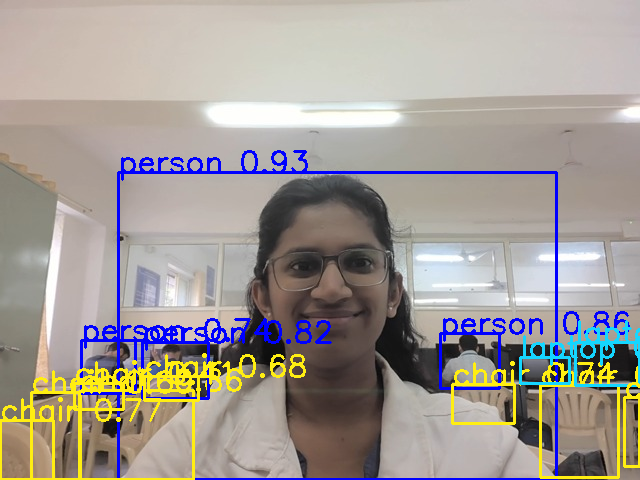


0: 480x640 4 persons, 9 chairs, 1 tv, 2 laptops, 1 cell phone, 434.4ms
Speed: 3.9ms preprocess, 434.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


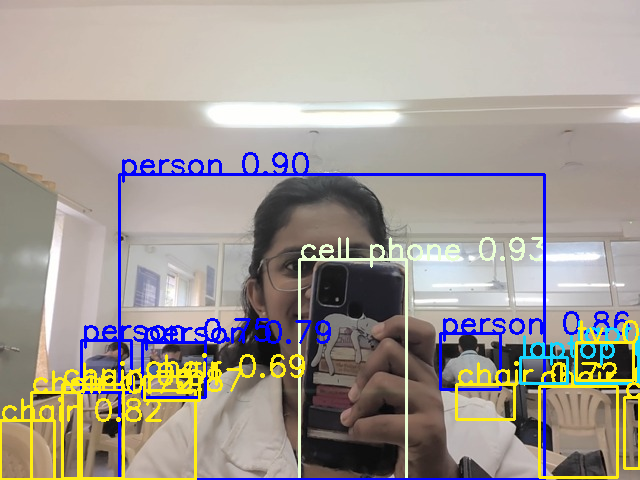

In [ ]:
# JavaScript code for capturing images
js_code = '''
function initCamera() {
    return new Promise((resolve, reject) => {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);
        const streamPromise = navigator.mediaDevices.getUserMedia({video: true});
        streamPromise.then((stream) => {
            video.srcObject = stream;
            video.onloadedmetadata = () => {
                resolve(video);
            };
            video.play();
        }).catch((error) => {
            reject(error);
        });
    });
}

async function takePhoto() {
    const video = await initCamera();
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const img = canvas.toDataURL('image/jpeg');
    return img;
}
'''

# Execute JavaScript code
display(Javascript(js_code))

# Function to convert base64 image to OpenCV format
def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_PIL = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image_PIL)
    frame = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame

# Load the YOLO model
yolo = YOLO('yolov8s.pt')

# Function to get class colors
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] *
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

# -----------------------
# MAIN LOOP (stop after 3 images)
# -----------------------
image_count = 0
max_images = 3

while True:
    # Capture image from the webcam
    js_reply = eval_js('takePhoto()')
    frame = js_to_image(js_reply)

    if frame is None:
        continue

    results = yolo.track(frame, stream=True)

    for result in results:
        # get the classes names
        classes_names = result.names

        # iterate over each box
        for box in result.boxes:
            # check if confidence is greater than 40 percent
            if box.conf[0] > 0.4:
                # get coordinates
                [x1, y1, x2, y2] = box.xyxy[0]
                # convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # get the class
                cls = int(box.cls[0])

                # get the class name
                class_name = classes_names[cls]

                # get the respective colour
                colour = getColours(cls)

                # draw the rectangle
                cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)

                # put the class name and confidence on the image
                cv2.putText(frame, f'{classes_names[int(box.cls[0])]} {box.conf[0]:.2f}',
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)

    # show the image
    cv2_imshow(frame)

    # increase counter
    image_count += 1

    # stop after 3 images
    if image_count >= max_images:
        break

# release resources
cv2.destroyAllWindows()
